In [1]:
import gc
import time
import numpy as np 
import pandas as pd 
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import recall_score

from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras.models import clone_model
from keras.layers import Dense,Conv2D,Flatten,MaxPool2D,Dropout,BatchNormalization, Input, AveragePooling2D
from keras.optimizers import Adam
from keras.callbacks import Callback

from keras.utils import plot_model
import matplotlib.pyplot as plt
import seaborn as sns
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

Using TensorFlow backend.


/kaggle/input/bengali-graphemes-croppedresized-100x100-train/train_data_0.feather
/kaggle/input/bengali-graphemes-croppedresized-100x100-train/train_data_1.feather
/kaggle/input/bengali-graphemes-croppedresized-100x100-train/train_data_2.feather
/kaggle/input/bengali-graphemes-croppedresized-100x100-train/train_data_3.feather
/kaggle/input/bengaliai-cv19/test_image_data_0.parquet
/kaggle/input/bengaliai-cv19/sample_submission.csv
/kaggle/input/bengaliai-cv19/test_image_data_3.parquet
/kaggle/input/bengaliai-cv19/train_image_data_0.parquet
/kaggle/input/bengaliai-cv19/test_image_data_1.parquet
/kaggle/input/bengaliai-cv19/train_image_data_2.parquet
/kaggle/input/bengaliai-cv19/train_image_data_3.parquet
/kaggle/input/bengaliai-cv19/test_image_data_2.parquet
/kaggle/input/bengaliai-cv19/train_image_data_1.parquet
/kaggle/input/bengaliai-cv19/class_map.csv
/kaggle/input/bengaliai-cv19/test.csv
/kaggle/input/bengaliai-cv19/train.csv


In [2]:
train_target = pd.read_csv('/kaggle/input/bengaliai-cv19/train.csv', index_col='image_id')

In [3]:
rootLB = LabelBinarizer()
vowelLB = LabelBinarizer()
consonantLB = LabelBinarizer()
rootLB.fit(train_target['grapheme_root'])
vowelLB.fit(train_target['vowel_diacritic'])
consonantLB.fit(train_target['consonant_diacritic'])

LabelBinarizer(neg_label=0, pos_label=1, sparse_output=False)

# Custom modules

## Custom metric callback

In [4]:
class validation_recall(keras.callbacks.Callback):
    
    def __init__(self, validation_data=()):
        super(keras.callbacks.Callback, self).__init__()
        self.X_val, self.y_val = validation_data
    
    def on_epoch_end(self, epoch, logs={}):

        root_val = self.y_val[0]
        vowel_val = self.y_val[1]
        consonant_val = self.y_val[2]
        
        # Predictions on validation set for the 3 targets 
        #(+ one hot encoding)
        preds = self.model.predict(self.X_val)
        root_preds = np.zeros_like(preds[0])
        root_preds[np.arange(len(preds[0])), 
                   preds[0].argmax(axis=1)] = 1
        vowel_preds = np.zeros_like(preds[1])
        vowel_preds[np.arange(len(preds[1])), 
                    preds[1].argmax(axis=1)] = 1
        consonant_preds = np.zeros_like(preds[2])
        consonant_preds[np.arange(len(preds[2])), 
                        preds[2].argmax(axis=1)] = 1
        
        # Recall calculation for the 3 targets
        root_recall = recall_score(root_val, root_preds, 
                                   average='macro')
        vowel_recall = recall_score(vowel_val, vowel_preds, 
                                    average='macro')
        consonant_recall = recall_score(consonant_val, consonant_preds, 
                                        average='macro')
        final_score = np.average([root_recall, vowel_recall, 
                                  consonant_recall], weights=[2,1,1])
        
        # Displaying scores at the end of each epoch
        print(' - root_recall: {0:.4f}'.format(root_recall)+\
              ' - vowel_recall: {0:.4f}'.format(vowel_recall)+\
              ' - consonant_recall: {0:.4f}'.format(consonant_recall)+\
              ' - final_score: {0:.4f}'.format(final_score))

        # Saving scores in logs history
        logs['root_recall'] = root_recall
        logs['vowel_recall'] = vowel_recall
        logs['consonant_recall'] = consonant_recall
        logs['final_score'] = final_score
        
        del root_val
        del vowel_val
        del consonant_val
        del preds 
        del root_preds 
        del vowel_preds
        del consonant_preds
        gc.collect()

## Custom data loader

Keras DataGenerator modified for multi-outputs model taken from [this very interesting notebook](https://www.kaggle.com/kaushal2896/bengali-graphemes-starter-eda-multi-output-cnn#Basic-Model) from Kaushal Shah. It will allow to generate a batch of data to feed the model while training to avoid memory shortage.

In [5]:
class MultiOutputDataGenerator(keras.preprocessing.image.ImageDataGenerator):

    def flow(self,
             x,
             y=None,
             batch_size=32,
             shuffle=True,
             sample_weight=None,
             seed=None,
             save_to_dir=None,
             save_prefix='',
             save_format='png',
             subset=None):

        targets = None
        target_lengths = {}
        ordered_outputs = []
        for output, target in y.items():
            if targets is None:
                targets = target
            else:
                targets = np.concatenate((targets, target), axis=1)
            target_lengths[output] = target.shape[1]
            ordered_outputs.append(output)


        for flowx, flowy in super().flow(x, targets, 
                                         batch_size=batch_size,
                                         shuffle=shuffle):
            target_dict = {}
            i = 0
            for output in ordered_outputs:
                target_length = target_lengths[output]
                target_dict[output] = flowy[:, i: i + target_length]
                i += target_length

            yield flowx, target_dict

# Model definition

In [6]:
def create_root_branch(inputs):
    
    x = Conv2D(32, (3, 3), padding="same", activation='relu')(inputs)
    x = Conv2D(32, (3, 3), padding="same", activation='relu')(x)
    x = Conv2D(32, (3, 3), padding="same", activation='relu')(x)
    x = BatchNormalization()(x)
    x = MaxPool2D(pool_size=(2, 2))(x)
    #x = Dropout(0.25)(x)
    
    x = Conv2D(64, (3, 3), padding="same", activation='relu')(x)
    x = Conv2D(64, (3, 3), padding="same", activation='relu')(x)
    x = Conv2D(64, (3, 3), padding="same", activation='relu')(x)
    x = BatchNormalization()(x)
    x = MaxPool2D(pool_size=(2, 2))(x)
    #x = Dropout(0.25)(x)
    
    x = Conv2D(128, (3, 3), padding="same", activation='relu')(x)
    x = Conv2D(128, (3, 3), padding="same", activation='relu')(x)
    x = Conv2D(128, (3, 3), padding="same", activation='relu')(x)
    x = BatchNormalization()(x)
    x = MaxPool2D(pool_size=(2, 2))(x)
    #x = Dropout(0.25)(x)
    
    x = Conv2D(256, (3, 3), padding="same", activation='relu')(x)
    x = Conv2D(256, (3, 3), padding="same", activation='relu')(x)
    x = Conv2D(256, (3, 3), padding="same", activation='relu')(x)
    x = BatchNormalization()(x)
    x = AveragePooling2D(pool_size=(3, 3), padding='valid')(x)
    #x = MaxPool2D(pool_size=(2, 2))(x)
    
    x = Flatten()(x)
    x = Dense(1024, activation = "relu")(x)
    x = Dropout(rate=0.3)(x)
    x = Dense(512, activation = "relu")(x)
    x = Dropout(rate=0.3)(x)
    
    root_out = Dense(168, activation='softmax', name='root_output')(x)
    #vowel_out = Dense(11, activation='softmax', name='vowel_output')(x)
    #consonant_out = Dense(7, activation='softmax', name='consonant_output')(x)

    #model = Model(inputs=inputs, outputs=[root_out, vowel_out, consonant_out])
    
    return root_out

In [7]:
def create_vowel_branch(inputs):
    
    x = Conv2D(32, (3, 3), padding="same", activation='relu')(inputs)
    x = Conv2D(32, (3, 3), padding="same", activation='relu')(x)
    x = Conv2D(32, (3, 3), padding="same", activation='relu')(x)
    x = BatchNormalization()(x)
    x = MaxPool2D(pool_size=(2, 2))(x)
    #x = Dropout(0.25)(x)
    
    x = Conv2D(64, (3, 3), padding="same", activation='relu')(x)
    x = Conv2D(64, (3, 3), padding="same", activation='relu')(x)
    x = Conv2D(64, (3, 3), padding="same", activation='relu')(x)
    x = BatchNormalization()(x)
    x = MaxPool2D(pool_size=(2, 2))(x)
    #x = Dropout(0.25)(x)
    
    x = Conv2D(128, (3, 3), padding="same", activation='relu')(x)
    x = Conv2D(128, (3, 3), padding="same", activation='relu')(x)
    x = Conv2D(128, (3, 3), padding="same", activation='relu')(x)
    x = BatchNormalization()(x)
    x = MaxPool2D(pool_size=(2, 2))(x)
    #x = Dropout(0.25)(x)
    
    x = Conv2D(256, (3, 3), padding="same", activation='relu')(x)
    x = Conv2D(256, (3, 3), padding="same", activation='relu')(x)
    x = Conv2D(256, (3, 3), padding="same", activation='relu')(x)
    x = BatchNormalization()(x)
    x = AveragePooling2D(pool_size=(3, 3), padding='valid')(x)
    #x = MaxPool2D(pool_size=(2, 2))(x)
    
    x = Flatten()(x)
    x = Dense(1024, activation = "relu")(x)
    x = Dropout(rate=0.3)(x)
    x = Dense(512, activation = "relu")(x)
    x = Dropout(rate=0.3)(x)
    
    #root_out = Dense(168, activation='softmax', name='root_output')(x)
    vowel_out = Dense(11, activation='softmax', name='vowel_output')(x)
    #consonant_out = Dense(7, activation='softmax', name='consonant_output')(x)

    #model = Model(inputs=inputs, outputs=[root_out, vowel_out, consonant_out])
    
    return vowel_out

In [8]:
def create_consonant_branch(inputs):
    
    x = Conv2D(32, (3, 3), padding="same", activation='relu')(inputs)
    x = Conv2D(32, (3, 3), padding="same", activation='relu')(x)
    x = Conv2D(32, (3, 3), padding="same", activation='relu')(x)
    x = BatchNormalization()(x)
    x = MaxPool2D(pool_size=(2, 2))(x)
    #x = Dropout(0.25)(x)
    
    x = Conv2D(64, (3, 3), padding="same", activation='relu')(x)
    x = Conv2D(64, (3, 3), padding="same", activation='relu')(x)
    x = Conv2D(64, (3, 3), padding="same", activation='relu')(x)
    x = BatchNormalization()(x)
    x = MaxPool2D(pool_size=(2, 2))(x)
    #x = Dropout(0.25)(x)
    
    x = Conv2D(128, (3, 3), padding="same", activation='relu')(x)
    x = Conv2D(128, (3, 3), padding="same", activation='relu')(x)
    x = Conv2D(128, (3, 3), padding="same", activation='relu')(x)
    x = BatchNormalization()(x)
    x = MaxPool2D(pool_size=(2, 2))(x)
    #x = Dropout(0.25)(x)
    
    x = Conv2D(256, (3, 3), padding="same", activation='relu')(x)
    x = Conv2D(256, (3, 3), padding="same", activation='relu')(x)
    x = Conv2D(256, (3, 3), padding="same", activation='relu')(x)
    x = BatchNormalization()(x)
    x = AveragePooling2D(pool_size=(3, 3), padding='valid')(x)
    #x = MaxPool2D(pool_size=(2, 2))(x)
    
    x = Flatten()(x)
    x = Dense(1024, activation = "relu")(x)
    x = Dropout(rate=0.3)(x)
    x = Dense(512, activation = "relu")(x)
    x = Dropout(rate=0.3)(x)
    
    #root_out = Dense(168, activation='softmax', name='root_output')(x)
    #vowel_out = Dense(11, activation='softmax', name='vowel_output')(x)
    consonant_out = Dense(7, activation='softmax', name='consonant_output')(x)

    #model = Model(inputs=inputs, outputs=[root_out, vowel_out, consonant_out])
    
    return consonant_out

In [9]:
def create_model():
    
    inputs = Input(shape=(80,80,1))
    root_branch = create_root_branch(inputs)
    vowel_branch = create_vowel_branch(inputs)
    consonant_branch = create_consonant_branch(inputs)
    model = Model(inputs=inputs, outputs=[root_branch, vowel_branch, consonant_branch])
    
    return model

# Training function :

This training function is using the following process :
* Loading a set of images and targets data (from one of the four images files)
* Reshape images data to numpy array with correct dimensions (100 x 100)
* One hot encoding of the 3 targets
* Separate all sets in two : training set and validation set
* Creating Keras data generators to load data batch by batch in the model
* Train the model


In [10]:
def train_model(model, epochs, batch_size):
    complete_history = []
    for i in range(4):

        # Images + targets loading and merging
        train_data = pd.read_feather('/kaggle/input/bengali-graphemes-'
                                     'croppedresized-100x100-train/'
                                     f'train_data_{i}.feather')
        train_data.set_index(keys=['image_id'], drop=True, inplace=True)
        train_df = pd.merge(train_data, train_target, 
                            on='image_id').drop(['grapheme'], axis=1)
        
        # Deleting previous variables to free up memory
        del train_data
        gc.collect()
        
        # One hot encoding the 3 targets with sklearn LabelBinarizer
        #rootLB = LabelBinarizer()
        #vowelLB = LabelBinarizer()
        #consonantLB = LabelBinarizer()
        rootLabels = rootLB.transform(train_df['grapheme_root'])
        vowelLabels = vowelLB.transform(train_df['vowel_diacritic'])
        consonantLabels = consonantLB.transform(
                          train_df['consonant_diacritic'])

        # Reshape images data to numpy array with same dimensions 
        # as images (80 x 80)
        train_df.drop(['grapheme_root', 'vowel_diacritic', 
                       'consonant_diacritic'], axis=1, inplace=True)
        train_df = train_df / 255
        train_images = train_df.values.reshape(-1, 80, 80, 1)
        
        # Deleting previous variables to free up memory
        del train_df
        gc.collect()

        # Creating Train / validation set for images and 3 targets
        X_train, X_val, y_train_root, y_val_root, y_train_vowel, \
        y_val_vowel, y_train_consonant, y_val_consonant \
        = train_test_split(train_images, rootLabels, vowelLabels, 
                           consonantLabels, test_size=0.1, 
                           random_state=42)
        
        # Deleting previous variables to free up memory
        del train_images
        del rootLabels, vowelLabels, consonantLabels
        gc.collect()

        # Creation of Keras Datagenerator configuration 
        # without data augmentation
        datagen = MultiOutputDataGenerator(
        featurewise_center=False,  
        samplewise_center=False,
        featurewise_std_normalization=False,
        samplewise_std_normalization=False,
        zca_whitening=False,
        rotation_range=0,
        zoom_range=0,
        width_shift_range=0,
        height_shift_range=0,
        horizontal_flip=False,
        vertical_flip=False)

        ''' You can use this piece of code to have insight of how the 
            datagen works and how batch are structured

        i = 0
        for batch in datagen.flow(X_train, 
                                 {'root': y_train_root, 
                                 'vowel': y_train_vowel, 
                                 'consonant': y_train_consonant},
                                  batch_size=1, save_to_dir=None):
            print(i)
            print('batch infos :')
            print(f'type : {type(batch)}')
            print(f'length type : {len(batch)}')
            print('features infos :')
            print(f'type : {type(batch[0])}')
            print(f'shape : {batch[0].shape}')
            print('Target infos :')
            print(f' global type : {type(batch[1])}')
            print(f'global shape : {len(batch[1])}')
            print(f'first target shape : {batch[1]["root"].shape}')
            print(f'second target shape : {batch[1]["vowel"].shape}')
            print(f'third target shape : {batch[1]["consonant"].shape}')

            i += 1
            if i > 5:
                break  # otherwise the generator would loop indefinitely

        '''
        # creation of data generator for training set
        train_generator = datagen.flow(X_train,
                                       {'root_output': y_train_root, 
                                        'vowel_output': y_train_vowel, 
                                        'consonant_output': y_train_consonant},
                                       batch_size=batch_size)
        
        # creation of data generator for validation set
        val_generator = datagen.flow(X_val,
                                     {'root_output': y_val_root, 
                                      'vowel_output': y_val_vowel, 
                                      'consonant_output': y_val_consonant},
                                     batch_size=batch_size)
        
        # Creation of callback for metric calculation
        # after each epoch
        my_call = validation_recall(validation_data=(X_val,
                                                     [y_val_root,
                                                      y_val_vowel, 
                                                      y_val_consonant]))
        
        # Model training
        history = model.fit_generator(
                train_generator,
                steps_per_epoch=X_train.shape[0] // batch_size,
                epochs=epochs,
                validation_data=val_generator,
                validation_steps=X_val.shape[0] // batch_size,
                callbacks=[my_call])
        
        # Appending training history to the one of previous
        complete_history.append(history.history)
        
        del train_generator
        del val_generator
        del my_call
        del X_train
        del X_val
        del y_train_root
        del y_val_root
        del y_train_vowel
        del y_val_vowel
        del y_train_consonant
        del y_val_consonant
        gc.collect()
        
        #time.sleep(10)
        
    return model, complete_history

# Model training

In [11]:
model = create_model()

In [12]:
model.compile(optimizer='adam', loss='categorical_crossentropy', 
              metrics=None)

In [13]:
trained_model, history = train_model(model=model, epochs=20, 
                                     batch_size=256)

Epoch 1/20
176/176 [==============================] - 109s 619ms/step - loss: 5.0781 - root_output_loss: 3.7781 - vowel_output_loss: 0.6621 - consonant_output_loss: 0.6379 - val_loss: 12.4517 - val_root_output_loss: 7.9826 - val_vowel_output_loss: 2.3344 - val_consonant_output_loss: 2.2744


/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


 - root_recall: 0.0073 - vowel_recall: 0.1192 - consonant_recall: 0.1842 - final_score: 0.0795
Epoch 2/20
176/176 [==============================] - 98s 557ms/step - loss: 2.2923 - root_output_loss: 1.6845 - vowel_output_loss: 0.3020 - consonant_output_loss: 0.3058 - val_loss: 7.8717 - val_root_output_loss: 5.8940 - val_vowel_output_loss: 1.0358 - val_consonant_output_loss: 1.1911
 - root_recall: 0.0420 - vowel_recall: 0.4357 - consonant_recall: 0.4564 - final_score: 0.2440
Epoch 3/20
176/176 [==============================] - 97s 552ms/step - loss: 1.3332 - root_output_loss: 0.8924 - vowel_output_loss: 0.2180 - consonant_output_loss: 0.2228 - val_loss: 3.3164 - val_root_output_loss: 2.4925 - val_vowel_output_loss: 0.3530 - val_consonant_output_loss: 0.5073
 - root_recall: 0.4063 - vowel_recall: 0.8066 - consonant_recall: 0.5548 - final_score: 0.5435
Epoch 4/20
176/176 [==============================] - 97s 551ms/step - loss: 0.9454 - root_output_loss: 0.5938 - vowel_output_loss: 0.170

/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


 - root_recall: 0.8425 - vowel_recall: 0.8706 - consonant_recall: 0.8749 - final_score: 0.8576
Epoch 2/20
176/176 [==============================] - 97s 553ms/step - loss: 0.4938 - root_output_loss: 0.3025 - vowel_output_loss: 0.0933 - consonant_output_loss: 0.0979 - val_loss: 0.9804 - val_root_output_loss: 0.5819 - val_vowel_output_loss: 0.1489 - val_consonant_output_loss: 0.2081
 - root_recall: 0.8233 - vowel_recall: 0.9399 - consonant_recall: 0.8559 - final_score: 0.8606
Epoch 3/20
176/176 [==============================] - 97s 552ms/step - loss: 0.3277 - root_output_loss: 0.2023 - vowel_output_loss: 0.0620 - consonant_output_loss: 0.0635 - val_loss: 0.8175 - val_root_output_loss: 0.4317 - val_vowel_output_loss: 0.1734 - val_consonant_output_loss: 0.1578
 - root_recall: 0.8694 - vowel_recall: 0.9454 - consonant_recall: 0.9337 - final_score: 0.9044
Epoch 4/20
176/176 [==============================] - 97s 553ms/step - loss: 0.2340 - root_output_loss: 0.1478 - vowel_output_loss: 0.041

/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


 - root_recall: 0.8657 - vowel_recall: 0.9499 - consonant_recall: 0.8703 - final_score: 0.8879
Epoch 2/20
176/176 [==============================] - 97s 551ms/step - loss: 0.4061 - root_output_loss: 0.2615 - vowel_output_loss: 0.0705 - consonant_output_loss: 0.0742 - val_loss: 0.8420 - val_root_output_loss: 0.3597 - val_vowel_output_loss: 0.1100 - val_consonant_output_loss: 0.1499
 - root_recall: 0.8797 - vowel_recall: 0.9640 - consonant_recall: 0.9153 - final_score: 0.9097
Epoch 3/20
176/176 [==============================] - 97s 552ms/step - loss: 0.2335 - root_output_loss: 0.1548 - vowel_output_loss: 0.0380 - consonant_output_loss: 0.0408 - val_loss: 0.6981 - val_root_output_loss: 0.3654 - val_vowel_output_loss: 0.1424 - val_consonant_output_loss: 0.1987
 - root_recall: 0.8832 - vowel_recall: 0.9582 - consonant_recall: 0.8867 - final_score: 0.9028
Epoch 4/20
176/176 [==============================] - 97s 553ms/step - loss: 0.1640 - root_output_loss: 0.1056 - vowel_output_loss: 0.027

In [14]:
model.save('multi_branch_CNN.h5')

# Results

In [15]:
results = {key: value + history[1][key] + history[2][key] +\
           history[3][key] for key, value in history[0].items()}
results_df = pd.DataFrame(results, columns=results.keys())

In [16]:
display(results_df)

,val_loss,val_root_output_loss,val_vowel_output_loss,val_consonant_output_loss,loss,root_output_loss,vowel_output_loss,consonant_output_loss,root_recall,vowel_recall,consonant_recall,final_score
0,12.451693,7.982618,2.334415,2.274352,5.078113,3.778103,0.662138,0.637872,0.007293,0.119200,0.184167,0.079488
1,7.871705,5.894032,1.035788,1.191072,2.290206,1.684508,0.301962,0.305839,0.041952,0.435680,0.456382,0.243992
2,3.316375,2.492519,0.352974,0.507292,1.332630,0.892407,0.217979,0.222806,0.406277,0.806598,0.554787,0.543485
3,1.555556,0.912747,0.224367,0.230783,0.944606,0.593785,0.170350,0.181256,0.727692,0.904176,0.832832,0.798098
4,0.960899,0.547215,0.190714,0.207285,0.718677,0.433137,0.141449,0.145174,0.809703,0.927089,0.853829,0.850081
...,...,...,...,...,...,...,...,...,...,...,...,...
75,1.094653,0.608210,0.397090,0.250353,0.074049,0.046058,0.016705,0.011729,0.891645,0.921557,0.921096,0.906486
76,1.310273,0.700324,0.216524,0.404538,0.062287,0.044703,0.008899,0.008608,0.886228,0.953392,0.880103,0.901488
77,0.977466,0.559997,0.232408,0.253424,0.058519,0.039618,0.009590,0.009376,0.891624,0.959547,0.933308,0.919026
78,0.818299,0.594869,0.267186,0.252158,0.060961,0.036799,0.012141,0.012089,0.900227,0.959128,0.942011,0.925399


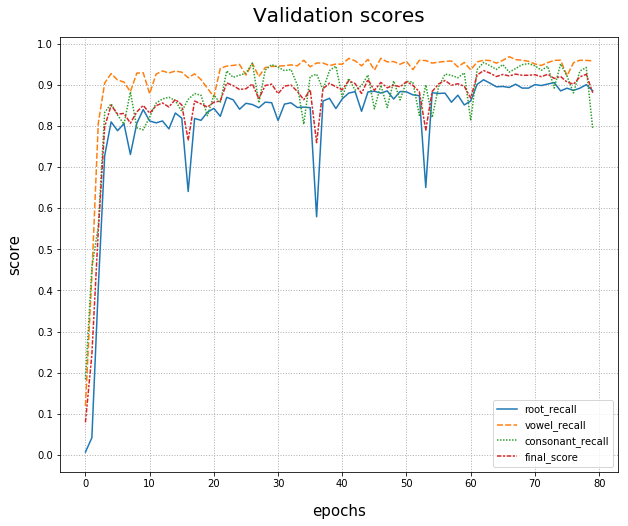

In [17]:
fig, ax = plt.subplots(figsize=(10,8))
ax = sns.lineplot(data=results_df.loc[:,['root_recall', 'vowel_recall', 
                                         'consonant_recall', 'final_score']], linestyle=None)
ax.set_xlabel('epochs', labelpad=15, fontsize=15)
ax.set_ylabel('score', labelpad=15, fontsize=15)
ax.set_title('Validation scores', pad=15, fontsize=20)
plt.yticks(np.arange(0, 1.1, step=0.1))
ax.grid(axis='both', linestyle=':', linewidth=1)

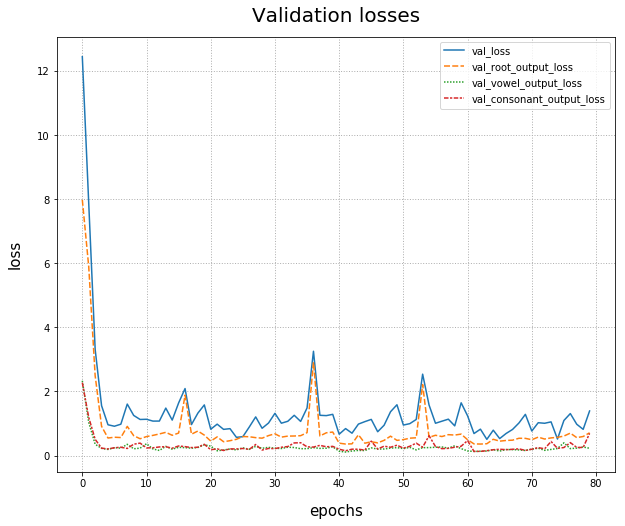

In [18]:
fig, ax1 = plt.subplots(figsize=(10,8))
ax1 = sns.lineplot(data=results_df.loc[:,['val_loss', 'val_root_output_loss', 'val_vowel_output_loss',
                                          'val_consonant_output_loss']], linestyle=None)
ax1.set_xlabel('epochs', labelpad=15, fontsize=15)
ax1.set_ylabel('loss', labelpad=15, fontsize=15)
ax1.set_title('Validation losses', pad=15, fontsize=20)
ax1.grid(axis='both', linestyle=':', linewidth=1)

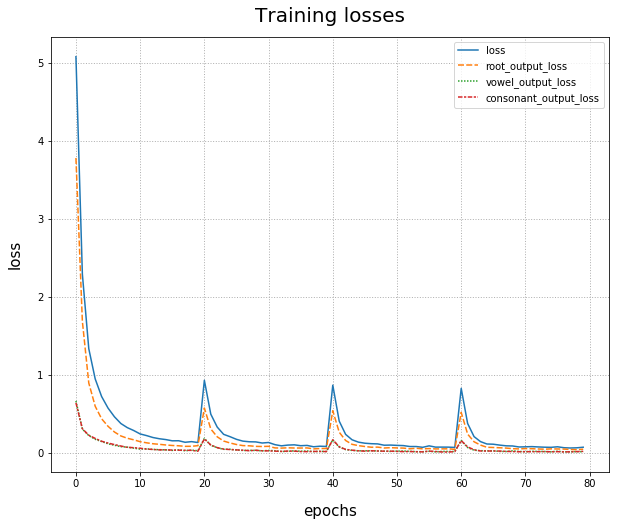

In [19]:
fig, ax2 = plt.subplots(figsize=(10,8))
ax2 = sns.lineplot(data=results_df.loc[:,['loss', 'root_output_loss','vowel_output_loss', 
                                          'consonant_output_loss']], linestyle=None)
ax2.set_xlabel('epochs', labelpad=15, fontsize=15)
ax2.set_ylabel('loss', labelpad=15, fontsize=15)
ax2.set_title('Training losses', pad=15, fontsize=20)
ax2.grid(axis='both', linestyle=':', linewidth=1)